# Deep Dream

This is an implementation of Deep Dream using Tensorflow. 

* DeepDream is a computer vision program created by Google engineer **Alexander Mordvintsev** which uses a convolutional neural network to find and enhance patterns in images via algorithmic pareidolia, thus creating a dream-like hallucinogenic appearance in the deliberately over-processed images.

* DeepDream is an experiment that visualizes the patterns learned by a neural network. Similar to when a child watches clouds and tries to interpret random shapes, DeepDream over-interprets and enhances the patterns it sees in an image.

* It does so by forwarding an image through the network, then calculating the gradient of the image with respect to the activations of a particular layer. The image is then modified to increase these activations, enhancing the patterns seen by the network, and resulting in a dream-like image. This process was dubbed "Inceptionism" (a reference to InceptionNet, and the movie Inception).

## Import Necessary Libraries


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
import IPython.display as display 

Check GPU 


In [0]:
!nvidia-smi

Mon Apr 13 09:54:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Util Functions

We'll go ahead and write some utitlity functions that would help us to smooth and ease certain things.

### Download function

This utility function is used to download image from specified URL with given name. We'll then use PILLOW library to read the image, resize it, and return it as a Numpy array.

In [0]:
def download(name, url, size):
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if size:
      img.thumbnail((size, size))
  return np.array(img)

### Show Image function

This utitlity function is used to visualize/display image in out notebook using IPython display. The function accepts an Image array and displays image.

In [0]:
def show_img(img):
  return display.display(PIL.Image.fromarray(np.array(img)))

### Normalize function

This utiltity function is used to normalize/deprocess the image. It returns normalized image.

In [0]:
def normalize(img):
  img = 255 * (img + 1.0) / 2.0
  return tf.cast(img, tf.uint8)

### Get Loss function

This function accepts image and model. Calculates and returns the losses by performing forward pass.

In [0]:
def get_loss(img, model):
  image = tf.expand_dims(img, axis=0)
  out = model(image)

  losses = []
  
  for val in out:
    loss = tf.math.reduce_mean(val)
    losses.append(loss)

  return tf.reduce_sum(losses)

## Build the model

* We'll be using Transfer Learning for this purpose. Inception V3 is the Convolutional Neural Network architecture that we'll be using to dream. 

* Inception V3 contains Mixed layers that can be used to transform our images using learned patterns from the image. For more information about Inception V3 and it's implementation, look at this [implementation of Inception V3 from fchollet's github](https://github.com/fchollet/deep-learning-models/blob/master/inception_v3.py).

* We'll use 4th, 8th, 7th, and 9th mixed layers.

* Base model's input and the above mentioned layers' output will be the new model that we'll be dreaming with. 

* Use `tf.keras.models.Model` to create the new model.

In [0]:
base_model = InceptionV3(include_top=False, weights='imagenet')

names = ['mixed4', 'mixed8', 'mixed7', 'mixed9']
layers = [base_model.get_layer(name).output for name in names]

model = Model(inputs=base_model.input, outputs=layers)

## Build Gradient Ascent class

* DeepDream will be our Gradient Ascent class. It accepts model as a parameter during instantiation.

* The loss for the chosen layers are calculated using our `get loss()` utility function. Next step is to calculate the gradients with respect to the image, and add them to the original image. 

* Adding the gradients to the image enhances the patterns seen by the network. At each step, you will have created an image that increasingly excites the activations of certain layers in the network.

* The method that does this, below, is wrapped in a `tf.function` for performance. It uses an `input_signature` to ensure that the function is not retraced for different image sizes or `steps`/`step_size` values. 

In [0]:
class DeepDream(tf.Module):
  def __init__(self, model):
    super().__init__()
    self.model = model

  @tf.function(input_signature=(tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32), 
                                tf.TensorSpec(shape=[], dtype=tf.int32), 
                                tf.TensorSpec(shape=[], dtype=tf.float32),
                                ))  
  def __call__(self, img, num_steps, step_size):
    loss = tf.constant(0.0)

    for i in tf.range(num_steps):
      with tf.GradientTape() as tape:
        tape.watch(img)
        loss = get_loss(img, self.model)

      grads = tape.gradient(loss, img)
      
      grads /= tf.math.reduce_std(grads) + 1e-8

      img = img + grads * step_size
      img = tf.clip_by_value(img, -1, 1)

    return img, loss

Instantiate the Gradient Ascent class with our model.

In [0]:
deep_dream = DeepDream(model)

## Dream function

We'll be using this function to dream with an image, which runs the main loop.

* Pre-process the image for the network using teh network class's `preprocess_input()`. 

* Convert it into a tensor and split the execution into parts.

* Use the `DeepDream` class and `get_loss()` function to perform forward pass and calculate the losses.

* Use the `normalize()` function to convert it back into an image from a tensor (deprocess).

* `clear_output` is used to clear output every iteration to keep the notebook clean and cell less flooded with outputs.

In [0]:
def dream(img, num_steps=100, step_size=0.01):
  img = preprocess_input(img)
  img = tf.convert_to_tensor(img)

  step_size = tf.convert_to_tensor(step_size)
  rem_steps = num_steps
  step = 0

  while rem_steps:
    if rem_steps > 100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(rem_steps)

    rem_steps -= run_steps
    step += run_steps

    img, loss = deep_dream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show_img(normalize(img))
    print(f"Step {step}  |  Loss {loss:.4f}")    

  dream_img = normalize(img)
  display.clear_output(wait=True)
  show_img(dream_img)
  
  return dream_img

## Test with an Image

* Download an image using our `download()` utility function by mentioning name, url and size.

* Visualise the image using `show_img()` utility function.

I have chosen an album art from one of my favorite Progressive Metal bands named **Opeth** as the test image. The album's name is Sorceress and it's album art looks dope.

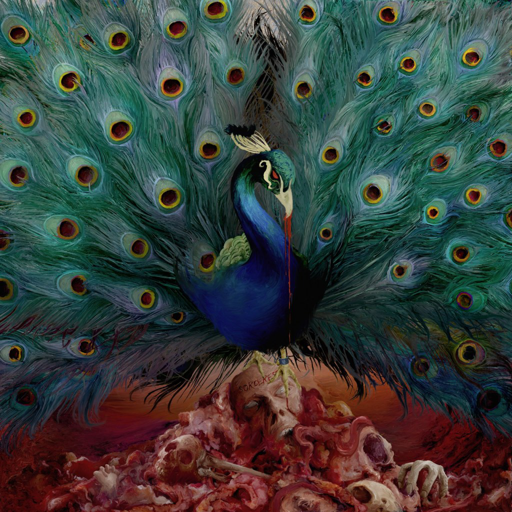

In [0]:
url = 'https://i1.wp.com/bloody-disgusting.com/wp-content/uploads/2016/07/Opeth-Sorceress-Front-cover-FINAL-JPG.jpg?resize=1024%2C1024&ssl=1'
our_img = download('sorceress', url, size=512)
show_img(our_img)

* Dream with the downloaded image for 20 iterations with a step size of 0.01.

* Visualize the resultant image.

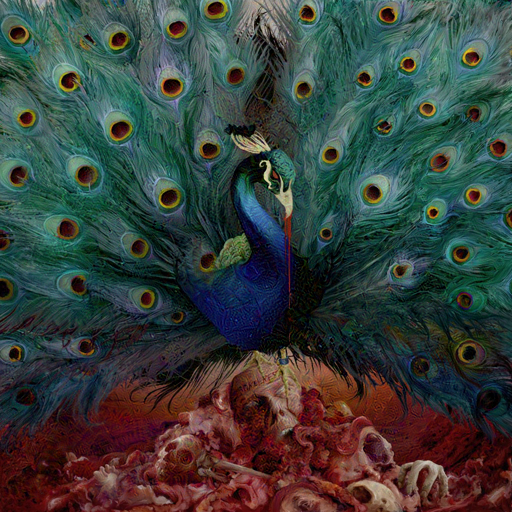

In [0]:
dream_img = dream(img=our_img, num_steps=20, step_size=0.01)

We can see changes and the resultant image is has more granular texture. This is primarily due to low quality and noise. This can be solved using Octaves.

## Using Octaves

* An octave is basically the size of the image.

* We basically resize the image to different scales and apply the gradient ascent algorithm. This will allow patterns generated at smaller scales to be incorporated into patterns at higher scales and filled in with additional detail.

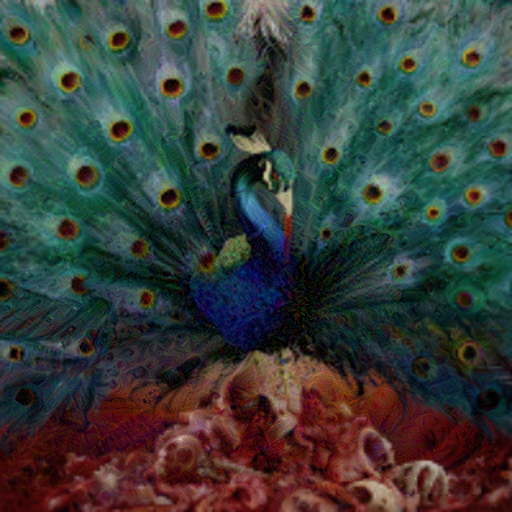

In [0]:
OCTAVE_SCALE = 1.6

img = tf.constant(np.array(our_img))
base_shape = tf.shape(img)[:-1]
oct_base_shape = base_shape
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 1):
    new_shape = tf.cast(float_base_shape * (OCTAVE_SCALE**n), tf.int32)

    img = tf.image.resize(img, new_shape).numpy()

    img = dream(img=img, num_steps=10, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img / 255.0, dtype=tf.uint8)
show_img(img)

## Random Roll function

This function allows us to generate random crops and shifts for the input image, which allows the model to learn better.

In [0]:
def random_roll(img, maxroll):
    shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
    
    shift_down, shift_right = shift[0], shift[1]

    img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
    
    return img_rolled, shift_right, shift_down

Perform random roll

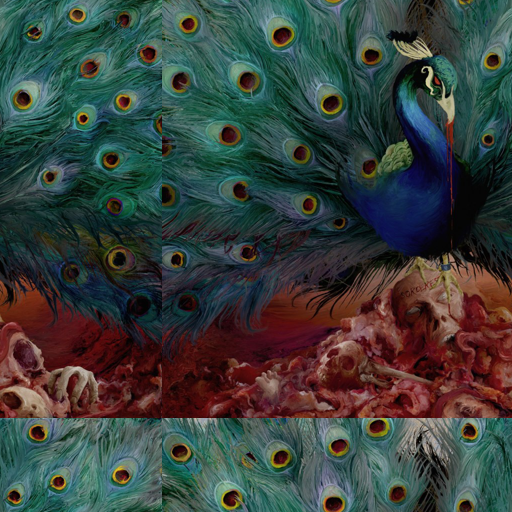

In [0]:
img_rolled, shift_right, shift_down = random_roll(our_img, 512)
show_img(img_rolled)

## Tiled Gradients

This class accepts model as an input parameter during instantiation. This basically does all the above mentioned processes such as `random_roll` and `octaves`. All fo these put together makes to model learn better and create a good image during the dream.

In [0]:
class TiledGradients(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(input_signature=(
        tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
    ))
    def __call__(self, img, tile_size=512):
        img_rolled, shift_right, shift_down = random_roll(img, tile_size)

        grads = tf.zeros_like(img_rolled)
        
        X = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
        
        if not tf.cast(len(X), bool):
            X = tf.constant([0])
        
        Y = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
        
        if not tf.cast(len(Y), bool):
            Y = tf.constant([0])

        for x in X:
            for y in Y:
                with tf.GradientTape() as tape:
                    tape.watch(img_rolled)

                    img_tile = img_rolled[x:x + tile_size, y:y + tile_size]
                    loss = get_loss(img_tile, self.model)

                grads = grads + tape.gradient(loss, img_rolled)

        grads = tf.roll(tf.roll(grads, -shift_right, axis=1), -shift_down, axis=0)

        grads /= tf.math.reduce_std(grads) + 1e-8

        return grads

Instantiate the TileGradients class with our model.

In [0]:
tiled_grad = TiledGradients(model)

## Octave Dream function

We'll be using this function to dream with an image by performing random_roll and octaves.

* Pre-process the image for the network using teh network class's `preprocess_input()`. 

* Convert it into a tensor and split the execution into parts.

* Use the `TiledGradients` class which performs the `random_roll` and `octaves` on the image per step, and `get_loss()` function to perform forward pass and calculate the losses.

* Use the `normalize()` function to convert it back into an image from a tensor (deprocess).

* `clear_output` is used to clear output every iteration to keep the notebook clean and cell less flooded with outputs.

In [0]:
def octave_dream(img, steps_per_octave=30, step_size=0.01, octaves=range(-2, 3), octave_scale=1.15):
  base_shape = tf.shape(img)
  img = preprocess_input(img)
  
  orig_shape = img.shape[:-1]
  img = tf.image.resize(img, orig_shape)

  for octave in octaves:
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32) * (octave_scale**octave)
    img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      grads = tiled_grad(img)
      img = img + grads * step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
          display.clear_output(wait=True)
          show_img(normalize(img))
          print(f"Octave {octave}  |  Step {step}")

  display.clear_output(wait=True)
  dream_img = normalize(img)
  dream_img = tf.image.resize(dream_img, orig_shape)
  dream_img = tf.image.convert_image_dtype(dream_img / 255.0, dtype=tf.uint8)
  show_img(dream_img)
  return dream_img

* Dream with the downloaded image for 30 iterations with a step size of 0.01 and a set of octaves/scales with an octave size of 1.6.

* Visualize the resultant image.

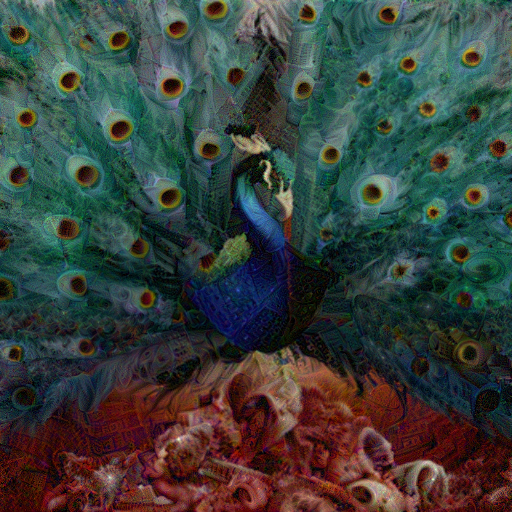

In [0]:
dream_img = octave_dream(img=our_img, steps_per_octave=30, step_size=0.01, octaves=[-1, 0, 1, 2], octave_scale=1.6)

The resultant image looks textured properly like a Canvas painting with some badass patterns in it. 

## Test with more images

### Galaxy

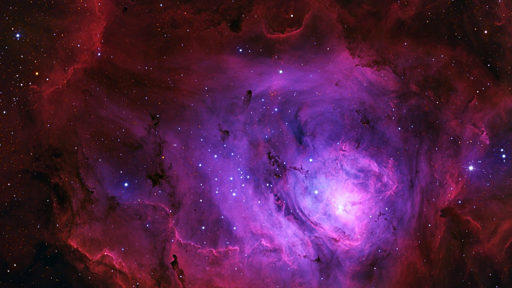

In [0]:
url = 'https://www.elsetge.cat/myimg/f/219-2193383_cosmos-purple-nebula-astronomical-object-outer-colors-galaxy.jpg'
our_img = download('galaxy', url, size=512)
show_img(our_img)

* We can see certain textures on the image.

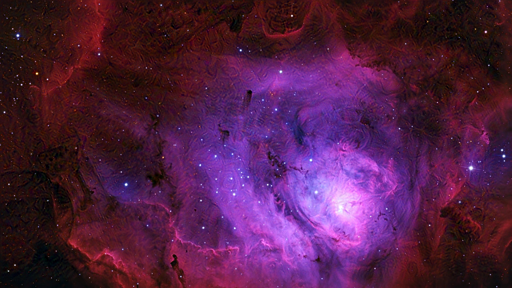

In [0]:
dream_img = dream(img=our_img, num_steps=15, step_size=0.01)

* The resultant image looks smoothened with certain patterns looking mellow and better than the original image.

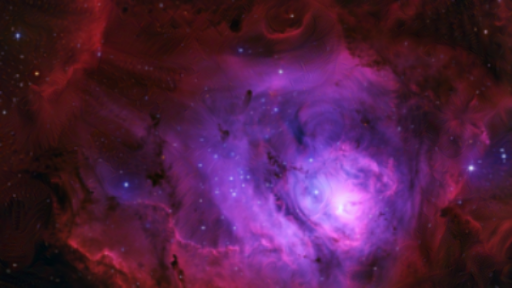

In [0]:
dream_img = octave_dream(img=our_img, steps_per_octave=15, step_size=0.001, octaves=[-2, -1, 0, 1], octave_scale=1.3)

### Valak

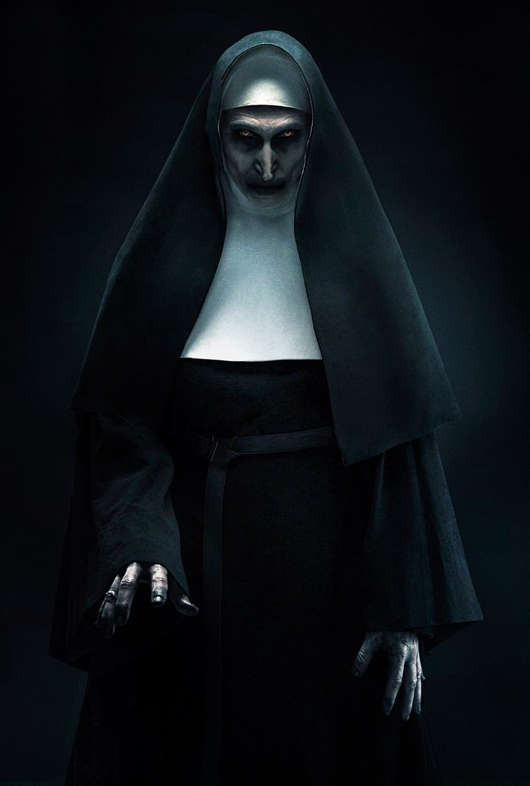

In [0]:
url = 'https://www.scifinow.co.uk/wp-content/uploads/2018/04/The-Nun-Teaser-Image.jpg'
our_img = download('valak', url, size=786)
show_img(our_img)

* We can see that the image has certain texture and patterns on it making it look trippy.

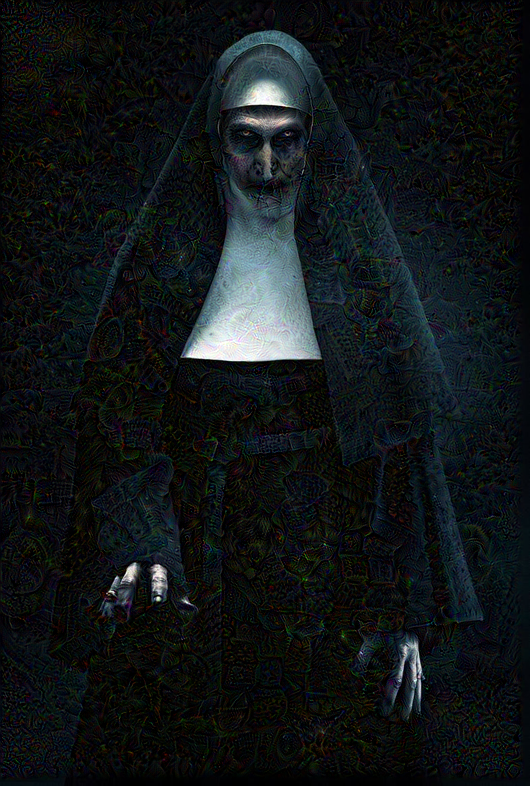

In [0]:
dream_img = dream(img=our_img, num_steps=100, step_size=0.01)

* The resultant image is filled with noisy pattern making it look more trippy and noisy. This is because of the black pixel noise in the original image.

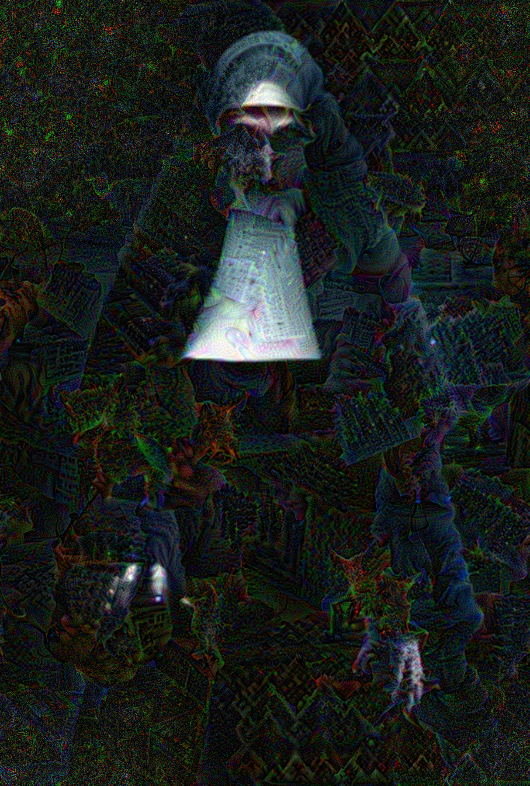

In [0]:
dream_img = octave_dream(img=our_img, steps_per_octave=100, step_size=0.01, octaves=[-3, -2, 0, 1, 5], octave_scale=1.3)